# Complete Fuzzing Pipeline Analysis

This notebook provides a comprehensive analysis of the entire fuzzing pipeline from patch arrival to test execution.

## Pipeline Stages:
1. **Patch Arrival & Parsing** - Load and parse the generated patch
2. **Repository Setup** - Clone repository and apply patch
3. **Singularity Container Build** - Build/verify the test execution container
4. **Static Analysis** - Code quality and syntax verification
5. **Existing Test Execution** - Run repository's existing test suite
6. **Patch Analysis** - Identify changed functions and lines
7. **Hypothesis Test Generation** - Generate targeted fuzz tests
8. **Test Execution** - Run generated tests in Singularity container
9. **Coverage Analysis** - Measure coverage of changed lines
10. **Results Evaluation** - Final verdict and metrics

## Setup and Imports

In [9]:
import sys
from pathlib import Path
import json
import time
from typing import Dict, Any
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add project root to path
PROJECT_ROOT = Path.cwd()
sys.path.append(str(PROJECT_ROOT))

# Import our modules
#from evaluation_pipeline import EvaluationPipeline
from verifier.dynamic_analyzers.patch_analyzer import PatchAnalyzer
from verifier.dynamic_analyzers.test_generator import HypothesisTestGenerator
from verifier.dynamic_analyzers.singularity_executor import SingularityTestExecutor
from verifier.dynamic_analyzers.coverage_analyzer import CoverageAnalyzer
import streamlit.modules.static_eval.static_modules.code_quality as code_quality
import streamlit.modules.static_eval.static_modules.syntax_structure as syntax_structure

# Configure plotting
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All imports successful")

/fs/nexus-scratch/ihbas/miniconda3/envs/verifier_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ All imports successful


## Stage 1: Patch Arrival & Parsing

Load a patch from SWE-bench or define a custom patch to analyze.

### Quick Start: Browse Available Repositories

Uncomment and run the cell below to see available repositories in the dataset.

In [ ]:
# Optional: Browse available repositories in the dataset
# Uncomment to see which repositories have samples

# from swebench_integration import DatasetLoader
# from collections import Counter

# loader = DatasetLoader(
#     source="princeton-nlp/SWE-bench_Verified",
#     hf_mode=True,
#     split="test"
# )

# repo_counts = Counter()
# for sample in loader.iter_samples(limit=100):  # Sample first 100
#     repo_counts[sample['repo']] += 1

# print("Available repositories (showing first 100 samples):")
# for repo, count in sorted(repo_counts.items(), key=lambda x: x[1], reverse=True):
#     print(f"  {repo}: {count} samples")

In [18]:
# Option 1: Load from SWE-bench dataset
from swebench_integration import DatasetLoader, PatchLoader

# ============================================
# CONFIGURATION: Select repository to analyze
# ============================================
# Options:
# - None: Get the first available sample
# - "pytest-dev/pytest": Filter for pytest repository
# - "django/django": Filter for Django repository
# - "astropy/astropy": Filter for astropy repository
# - etc.

REPO_FILTER = "pytest-dev/pytest"  # Change this to select different repos
NUM_SAMPLES = 1  # How many samples to load

# ============================================

# Load a sample from SWE-bench
loader = DatasetLoader(
    source="princeton-nlp/SWE-bench_Verified",
    hf_mode=True,
    split="test"
)

# Get sample with optional repository filter
sample = None
for s in loader.iter_samples(limit=NUM_SAMPLES, filter_repo=REPO_FILTER):
    sample = s
    break

if sample:
    print(f"✓ Loaded sample: {sample.get('metadata', {}).get('instance_id', 'unknown')}")
    print(f"  Repository: {sample['repo']}")
    print(f"  Base commit: {sample['base_commit'][:8]}...")
    print(f"\n📝 Problem Statement:")
    print(sample.get('problem_statement', 'N/A')[:300] + "...")
else:
    print(f"❌ Failed to load sample for repository: {REPO_FILTER}")
    print("Available repositories in SWE-bench_Verified:")
    print("  - pytest-dev/pytest")
    print("  - django/django")
    print("  - astropy/astropy")
    print("  - sympy/sympy")
    print("  - scikit-learn/scikit-learn")
    print("  - matplotlib/matplotlib")
    print("  - and many more...")

✓ Loaded sample: pytest-dev__pytest-10051
  Repository: pytest-dev/pytest
  Base commit: aa55975c...

📝 Problem Statement:
caplog.get_records and caplog.clear conflict
# Description

`caplog.get_records()` gets decoupled from actual caplog records when `caplog.clear()` is called. As a result, after `caplog.clear()` is called, `caplog.get_records()` is frozen: it does not get cleared, nor does it get new records.

Du...


In [ ]:
# Option 2: Define custom patch for testing
# Uncomment and modify this section to use a custom patch

# custom_patch = {
#     'id': 'custom-001',
#     'diff': """
# --- a/example.py
# +++ b/example.py
# @@ -10,6 +10,8 @@ def divide(a, b):
# +    if b == 0:
# +        raise ValueError("Cannot divide by zero")
#      return a / b
# """,
#     'patched_code': """
# def divide(a, b):
#     if b == 0:
#         raise ValueError("Cannot divide by zero")
#     return a / b
# """,
#     'repo_path': '/path/to/your/repo'
# }
# sample = custom_patch

In [19]:
# Display the patch
print("📄 Patch Content:")
print("=" * 80)
print(sample['patch'])
print("=" * 80)

📄 Patch Content:
diff --git a/src/_pytest/logging.py b/src/_pytest/logging.py
--- a/src/_pytest/logging.py
+++ b/src/_pytest/logging.py
@@ -40,7 +40,6 @@
 else:
     logging_StreamHandler = logging.StreamHandler
 
-
 DEFAULT_LOG_FORMAT = "%(levelname)-8s %(name)s:%(filename)s:%(lineno)d %(message)s"
 DEFAULT_LOG_DATE_FORMAT = "%H:%M:%S"
 _ANSI_ESCAPE_SEQ = re.compile(r"\x1b\[[\d;]+m")
@@ -345,6 +344,10 @@ def reset(self) -> None:
         self.records = []
         self.stream = StringIO()
 
+    def clear(self) -> None:
+        self.records.clear()
+        self.stream = StringIO()
+
     def handleError(self, record: logging.LogRecord) -> None:
         if logging.raiseExceptions:
             # Fail the test if the log message is bad (emit failed).
@@ -440,7 +443,7 @@ def messages(self) -> List[str]:
 
     def clear(self) -> None:
         """Reset the list of log records and the captured log text."""
-        self.handler.reset()
+        self.handler.clear()
 
     def set_level

### Important Notes on Container Images:

1. **Generic Image**: The default image includes common testing tools (pytest, hypothesis, coverage)
2. **Repository-Specific Dependencies**: Some repositories may require additional dependencies
   - For **pytest**: The repository itself contains pytest, so the generic image should work
   - For **Django**: May need Django installed in the container
   - For **astropy**: May need numpy, scipy, etc.

3. **Dependency Installation**: Repository dependencies are installed at runtime when tests are executed
   - The `SingularityTestExecutor` will attempt to install dependencies from the repo's setup.py/pyproject.toml
   - This happens automatically during test execution

4. **Build Time**: First build takes ~5-10 minutes. Subsequent runs are instant if image exists.

In [ ]:
from verifier.dynamic_analyzers.test_patch_singularity import build_singularity_image

# Configure container image path
CONTAINER_IMAGE_PATH = "/fs/nexus-scratch/ihbas/.containers/singularity/verifier-swebench.sif"
PYTHON_VERSION = "3.11"  # Adjust based on repository requirements
FORCE_REBUILD = False  # Set to True to force rebuild even if image exists

print("🐳 Building/Verifying Singularity Container Image...")
print(f"Image path: {CONTAINER_IMAGE_PATH}")
print(f"Python version: {PYTHON_VERSION}")
print()

try:
    # Build or verify the container image
    # This will skip building if the image already exists (unless force_rebuild=True)
    image_path = build_singularity_image(
        image_path=CONTAINER_IMAGE_PATH,
        python_version=PYTHON_VERSION,
        force_rebuild=FORCE_REBUILD
    )
    
    print(f"\n✅ Container image ready at: {image_path}")
    print(f"   Size: {Path(image_path).stat().st_size / (1024**2):.1f} MB")
    
    # Verify we can run a simple command
    print("\n🔍 Verifying container functionality...")
    result = subprocess.run(
        ["singularity", "exec", str(image_path), "python", "--version"],
        capture_output=True,
        text=True
    )
    
    if result.returncode == 0:
        print(f"✓ Container test successful: {result.stdout.strip()}")
    else:
        print(f"⚠️ Container test failed: {result.stderr}")
        
except Exception as e:
    print(f"❌ Container build/verification failed: {e}")
    import traceback
    traceback.print_exc()
    print("\n⚠️ You may need to build the container manually:")
    print(f"   python test_singularity_build.py")
    # Don't exit - allow continuing for static analysis even if container fails

## Stage 2.5: Build Singularity Container Image

Build the Singularity container image that will be used for isolated test execution.

This step is **critical** for the fuzzing pipeline - the container provides an isolated environment for running tests.

## Stage 2: Repository Setup

Clone the repository and apply the patch.

In [20]:
# Setup repository
patcher = PatchLoader(
    sample=sample,
    repos_root="./repos_temp"
)

# Clone repository
print("🔄 Cloning repository...")
repo_path = patcher.clone_repository()
print(f"✓ Repository cloned to: {repo_path}")

# Apply patch
print("\n🔧 Applying patch...")
patch_result = patcher.apply_patch()

if patch_result['applied']:
    print("✓ Patch applied successfully")
else:
    print(f"❌ Patch application failed: {patch_result.get('log', 'Unknown error')}")
    
print(f"\n📁 Working directory: {repo_path}")

🔄 Cloning repository...
[+] Cloning pytest-dev/pytest into /fs/nexus-scratch/ihbas/verifier_harness/repos_temp/pytest-dev__pytest ...
✓ Repository cloned to: /fs/nexus-scratch/ihbas/verifier_harness/repos_temp/pytest-dev__pytest

🔧 Applying patch...
✓ Patch applied successfully

📁 Working directory: /fs/nexus-scratch/ihbas/verifier_harness/repos_temp/pytest-dev__pytest


## Stage 3: Static Analysis

Run comprehensive static analysis on the patched code.

In [ ]:
## Stage 4: Existing Test Execution

Run the repository's existing test suite **inside the Singularity container** to establish baseline.

This ensures:
- Consistent test environment between existing and generated tests
- Proper isolation and reproducibility
- Uses SWE-bench metadata (FAIL_TO_PASS and PASS_TO_PASS tests) if available

In [ ]:
# First, install the repository's dependencies in the container
# This is necessary for both existing tests and our generated tests

print("📦 Installing repository dependencies in container...")

# Check if the repo has setup.py, pyproject.toml, or requirements files
setup_py = Path(repo_path) / "setup.py"
pyproject = Path(repo_path) / "pyproject.toml"
requirements = Path(repo_path) / "requirements.txt"
setup_cfg = Path(repo_path) / "setup.cfg"

install_cmd = None

if setup_py.exists():
    print(f"  Found setup.py - installing with pip install -e .")
    install_cmd = "cd /workspace && pip install -e . --quiet"
elif pyproject.toml.exists():
    print(f"  Found pyproject.toml - installing with pip install -e .")
    install_cmd = "cd /workspace && pip install -e . --quiet"
elif requirements.exists():
    print(f"  Found requirements.txt - installing requirements")
    install_cmd = "cd /workspace && pip install -r requirements.txt --quiet"
else:
    print(f"  ⚠️ No setup.py, pyproject.toml, or requirements.txt found")
    print(f"  Proceeding without dependency installation - tests may fail")

if install_cmd:
    try:
        result = subprocess.run(
            [
                "singularity", "exec",
                "--bind", f"{repo_path}:/workspace",
                "--pwd", "/workspace",
                CONTAINER_IMAGE_PATH,
                "bash", "-c", install_cmd
            ],
            capture_output=True,
            text=True,
            timeout=300  # 5 minute timeout for installation
        )
        
        if result.returncode == 0:
            print("  ✓ Dependencies installed successfully")
        else:
            print(f"  ⚠️ Dependency installation had issues (exit code: {result.returncode})")
            print(f"  Last 500 chars of output:")
            output = result.stdout + "\n" + result.stderr
            print(output[-500:] if len(output) > 500 else output)
            
    except subprocess.TimeoutExpired:
        print("  ⏱️ Dependency installation timed out after 5 minutes")
    except Exception as e:
        print(f"  ❌ Error installing dependencies: {e}")

print()

In [ ]:
# Run existing test suite inside the Singularity container
# This ensures consistency with how we'll run our generated tests

print("🧪 Running existing test suite in Singularity container...")
print("(This may take a while depending on the repository)\n")

try:
    # Get the test commands from the sample metadata if available
    fail_to_pass = sample.get('metadata', {}).get('FAIL_TO_PASS', '[]')
    pass_to_pass = sample.get('metadata', {}).get('PASS_TO_PASS', '[]')
    
    # Parse test paths
    import ast
    try:
        fail_to_pass_tests = ast.literal_eval(fail_to_pass) if isinstance(fail_to_pass, str) else fail_to_pass
        pass_to_pass_tests = ast.literal_eval(pass_to_pass) if isinstance(pass_to_pass, str) else pass_to_pass
    except:
        fail_to_pass_tests = []
        pass_to_pass_tests = []
    
    all_tests = fail_to_pass_tests + pass_to_pass_tests
    
    if all_tests:
        print(f"Found {len(all_tests)} tests to run from metadata:")
        print(f"  - FAIL_TO_PASS: {len(fail_to_pass_tests)}")
        print(f"  - PASS_TO_PASS: {len(pass_to_pass_tests)}")
        test_args = " ".join(all_tests)
    else:
        print("No specific tests in metadata, running general test discovery")
        test_args = "-v"
    
    # Build the pytest command
    pytest_cmd = f"cd /workspace && python -m pytest {test_args} --tb=short -x"
    
    print(f"\nExecuting: {pytest_cmd}\n")
    
    # Run tests in Singularity container
    result = subprocess.run(
        [
            "singularity", "exec",
            "--bind", f"{repo_path}:/workspace",
            "--pwd", "/workspace",
            CONTAINER_IMAGE_PATH,
            "bash", "-c", pytest_cmd
        ],
        capture_output=True,
        text=True,
        timeout=300  # 5 minute timeout
    )
    
    print(f"Exit code: {result.returncode}")
    print(f"\n{'='*80}")
    print("Test Output (last 2000 chars):")
    print("="*80)
    
    # Combine stdout and stderr
    output = result.stdout + "\n" + result.stderr
    print(output[-2000:] if len(output) > 2000 else output)
    print("="*80)
    
    if result.returncode == 0:
        print("\n✓ All existing tests passed")
        existing_tests_passed = True
    else:
        print(f"\n⚠️ Some tests failed (exit code: {result.returncode})")
        existing_tests_passed = False
        
        # For FAIL_TO_PASS tests, failures are expected before the patch
        if fail_to_pass_tests:
            print(f"\nNote: {len(fail_to_pass_tests)} tests are expected to fail before patch (FAIL_TO_PASS)")
        
except subprocess.TimeoutExpired:
    print("⏱️ Test execution timed out after 5 minutes")
    existing_tests_passed = False
except FileNotFoundError as e:
    print(f"❌ Command not found: {e}")
    print("Make sure Singularity is installed and the container image exists")
    existing_tests_passed = False
except Exception as e:
    print(f"❌ Error running tests: {e}")
    import traceback
    traceback.print_exc()
    existing_tests_passed = False

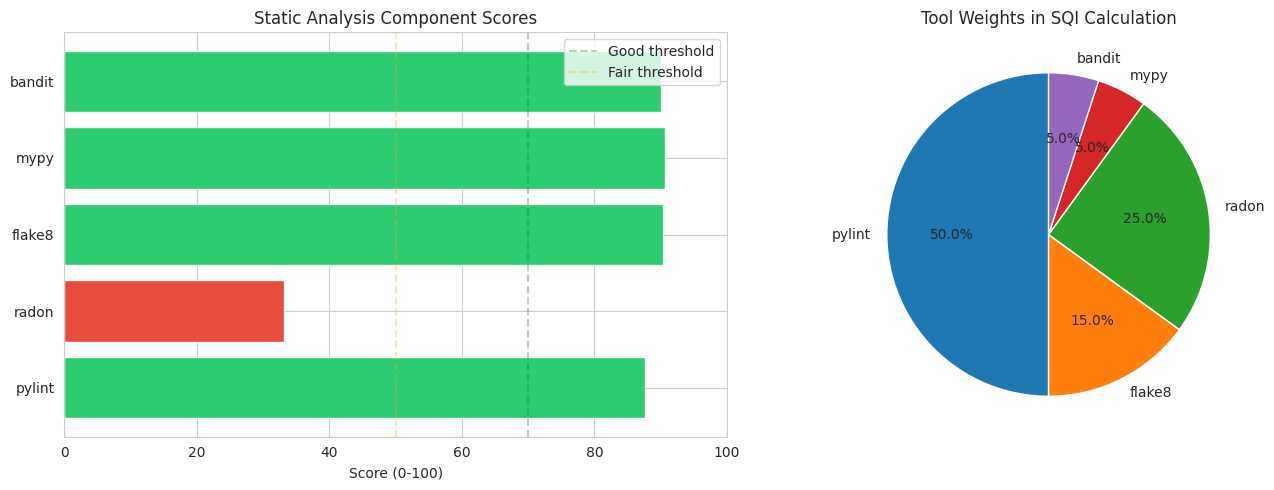

In [23]:
# Visualize SQI components
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart of component scores
components = sqi_data.get('components', {})
tools = list(components.keys())
scores = list(components.values())

colors = ['#2ecc71' if s >= 70 else '#f39c12' if s >= 50 else '#e74c3c' for s in scores]
ax1.barh(tools, scores, color=colors)
ax1.set_xlabel('Score (0-100)')
ax1.set_title('Static Analysis Component Scores')
ax1.set_xlim(0, 100)
ax1.axvline(x=70, color='green', linestyle='--', alpha=0.3, label='Good threshold')
ax1.axvline(x=50, color='orange', linestyle='--', alpha=0.3, label='Fair threshold')
ax1.legend()

# Pie chart of weights
weights = sqi_data.get('weights_used', {})
ax2.pie(weights.values(), labels=weights.keys(), autopct='%1.1f%%', startangle=90)
ax2.set_title('Tool Weights in SQI Calculation')

plt.tight_layout()
plt.show()

In [24]:
# Display syntax and structure metrics
print("\n" + "=" * 80)
print("SYNTAX & STRUCTURE ANALYSIS")
print("=" * 80)

for file_report in ss_results:
    print(f"\n📄 File: {file_report.get('path', 'Unknown')}")
    
    if file_report.get('is_code_valid'):
        print("  ✓ Valid Python syntax")
        print(f"  Functions: {file_report.get('n_functions', 0)}")
        print(f"  Classes: {file_report.get('n_classes', 0)}")
        print(f"  AST Depth: {file_report.get('ast_depth', 0)}")
        print(f"  Avg Function Length: {file_report.get('avg_func_length', 0):.1f} lines")
        
        if file_report.get('changed_functions'):
            print(f"  Changed Functions: {', '.join(file_report['changed_functions'])}")
        
        if 'ast_diff_ratio' in file_report:
            print(f"  Structure Change Ratio: {file_report['ast_diff_ratio']:.1%}")
    else:
        print(f"  ❌ Syntax Error: {file_report.get('error', 'Unknown error')}")

print("=" * 80)


SYNTAX & STRUCTURE ANALYSIS

📄 File: /fs/nexus-scratch/ihbas/verifier_harness/repos_temp/pytest-dev__pytest/src/_pytest/logging.py
  ✓ Valid Python syntax
  Functions: 57
  Classes: 9
  AST Depth: 12
  Avg Function Length: 10.1 lines
  Changed Functions: reset, clear, handleError, clear, set_level
  Structure Change Ratio: 7.6%


## Stage 4: Existing Test Execution

Run the repository's existing test suite to establish baseline.

In [25]:
# Note: This section assumes the repository has a test suite
# You may need to adapt this based on the specific repository structure

import subprocess

print("🧪 Running existing test suite...")
print("(This may take a while depending on the repository)\n")

try:
    # Try pytest first (most common)
    result = subprocess.run(
        ['pytest', '-v', '--tb=short'],
        cwd=repo_path,
        capture_output=True,
        text=True,
        timeout=300  # 5 minute timeout
    )
    
    print(f"Exit code: {result.returncode}")
    print(f"\n{'='*80}")
    print("Test Output (last 2000 chars):")
    print(result.stdout[-2000:] if len(result.stdout) > 2000 else result.stdout)
    
    if result.returncode == 0:
        print("\n✓ All existing tests passed")
    else:
        print("\n⚠️ Some tests failed or had errors")
        
except subprocess.TimeoutExpired:
    print("⏱️ Test execution timed out after 5 minutes")
except FileNotFoundError:
    print("⚠️ pytest not found. Skipping existing test execution.")
except Exception as e:
    print(f"❌ Error running tests: {e}")

🧪 Running existing test suite...
(This may take a while depending on the repository)

Exit code: 2

Test Output (last 2000 chars):
], package, level)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
testing/test_junitxml.py:13: in <module>
    import xmlschema
E   ModuleNotFoundError: No module named 'xmlschema'
__________________ ERROR collecting testing/test_pytester.py ___________________
ImportError while importing test module '/fs/nexus-scratch/ihbas/verifier_harness/repos_temp/pytest-dev__pytest/testing/test_pytester.py'.
Hint: make sure your test modules/packages have valid Python names.
Traceback:
../../../miniconda3/envs/verifier_env/lib/python3.11/importlib/__init__.py:126: in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
testing/test_pytester.py:14: in <module>
    from _pytest.pytester import CwdSnapshot
E   ImportError: cannot import name 'CwdSnapshot' from '_pyte

## Stage 5: Patch Analysis

Analyze the patch to identify changed functions and lines.

In [ ]:
# Initialize patch analyzer
patch_analyzer = PatchAnalyzer()

print("🔍 Analyzing patch to identify changes...")

# Parse the patch
# Note: We need the patched code content for analysis
# For SWE-bench samples, we can read the modified files from the repo

# Get modified files from the patch
from verifier.utils.diff_utils import parse_unified_diff, filter_paths_to_py

parsed_diff = parse_unified_diff(sample['patch'])
modified_files = filter_paths_to_py(list(parsed_diff.keys()))

print(f"\nModified Python files: {len(modified_files)}")
for f in modified_files:
    print(f"  - {f}")

# Read the patched code from the first modified file
if modified_files:
    first_file = Path(repo_path) / modified_files[0]
    if first_file.exists():
        patched_code = first_file.read_text(encoding='utf-8')
        
        # Analyze the patch
        patch_analysis = patch_analyzer.parse_patch(sample['patch'], patched_code)
        
        print(f"\n📊 Patch Analysis Results:")
        print(f"  Changed functions: {patch_analysis.changed_functions}")
        print(f"  Total changed lines: {len(patch_analysis.all_changed_lines)}")
        print(f"  Change types: {patch_analysis.change_types}")
        print(f"\n  Changed lines by file:")
        for file, lines in patch_analysis.changed_lines.items():
            print(f"    {file}: {sorted(lines)}")
    else:
        print(f"⚠️ File not found: {first_file}")
        patch_analysis = None
else:
    print("⚠️ No Python files modified in patch")
    patch_analysis = None

## Stage 6: Hypothesis Test Generation

Generate targeted fuzz tests based on the patch analysis.

**Note:** This is where you can customize when tests are generated. Current implementation generates tests after identifying changed code, but you could modify this to generate tests at different stages based on your optimization strategy.

In [ ]:
if patch_analysis and patch_analysis.changed_functions:
    print("🧬 Generating hypothesis-based fuzz tests...")
    
    # Initialize test generator
    test_generator = HypothesisTestGenerator()
    
    # Generate tests
    test_code = test_generator.generate_tests(patch_analysis, patched_code)
    
    # Count generated tests
    test_count = test_code.count('def test_')
    
    print(f"✓ Generated {test_count} test functions")
    print(f"\n📝 Generated Test Code Preview:")
    print("=" * 80)
    print(test_code[:1500] + "\n..." if len(test_code) > 1500 else test_code)
    print("=" * 80)
    
else:
    print("⚠️ No functions changed, skipping test generation")
    test_code = None
    test_count = 0

if test_code:
    print("🐳 Executing tests in Singularity container...")
    print("(This may take a few minutes)\n")
    
    # Initialize executor with the image we built/verified earlier
    executor = SingularityTestExecutor(
        image_path=CONTAINER_IMAGE_PATH,  # Use the image from Stage 2.5
        timeout=120
    )
    
    start_time = time.time()
    
    try:
        # Run tests with existing infrastructure
        success, output, coverage_data = executor.run_tests_with_existing_infrastructure(
            repo_path=Path(repo_path),
            test_code=test_code
        )
        
        execution_time = time.time() - start_time
        
        print(f"\n{'='*80}")
        print(f"Test Execution Results")
        print(f"{'='*80}")
        print(f"Status: {'✓ PASSED' if success else '❌ FAILED'}")
        print(f"Execution time: {execution_time:.2f}s")
        print(f"\nTest Output (last 1000 chars):")
        print(output[-1000:] if len(output) > 1000 else output)
        print(f"{'='*80}")
        
    except Exception as e:
        print(f"❌ Test execution error: {e}")
        import traceback
        traceback.print_exc()
        success = False
        coverage_data = {}
else:
    print("⚠️ No tests to execute")
    success = True
    coverage_data = {}

In [ ]:
# # Example: Adaptive test generation based on SQI score
# sqi_score = sqi_data.get('SQI', 0)

# if sqi_score >= 70:
#     print("✓ High SQI score - generating focused tests")
#     # Generate fewer, more targeted tests
#     test_generator.max_examples = 50
# elif sqi_score >= 50:
#     print("⚠️ Medium SQI score - generating standard tests")
#     # Standard test generation
#     test_generator.max_examples = 100
# else:
#     print("❌ Low SQI score - generating comprehensive tests")
#     # Generate more extensive tests to catch potential issues
#     test_generator.max_examples = 200

# # Regenerate tests with new settings
# if patch_analysis and patch_analysis.changed_functions:
#     test_code = test_generator.generate_tests(patch_analysis, patched_code)

## Stage 7: Test Execution in Singularity Container

Execute the generated tests in an isolated Singularity container with coverage tracking.

In [ ]:
if test_code:
    print("🐳 Executing tests in Singularity container...")
    print("(This may take a few minutes)\n")
    
    # Initialize executor
    executor = SingularityTestExecutor(
        image_path="/fs/nexus-scratch/ihbas/.containers/singularity/verifier-swebench.sif",
        timeout=120
    )
    
    start_time = time.time()
    
    try:
        # Run tests with existing infrastructure
        success, output, coverage_data = executor.run_tests_with_existing_infrastructure(
            repo_path=Path(repo_path),
            test_code=test_code
        )
        
        execution_time = time.time() - start_time
        
        print(f"\n{'='*80}")
        print(f"Test Execution Results")
        print(f"{'='*80}")
        print(f"Status: {'✓ PASSED' if success else '❌ FAILED'}")
        print(f"Execution time: {execution_time:.2f}s")
        print(f"\nTest Output (last 1000 chars):")
        print(output[-1000:] if len(output) > 1000 else output)
        print(f"{'='*80}")
        
    except Exception as e:
        print(f"❌ Test execution error: {e}")
        import traceback
        traceback.print_exc()
        success = False
        coverage_data = {}
else:
    print("⚠️ No tests to execute")
    success = True
    coverage_data = {}

## Stage 8: Coverage Analysis

Analyze test coverage specifically for the changed lines (change-aware coverage).

In [ ]:
if patch_analysis and coverage_data:
    print("📊 Analyzing coverage of changed lines...")
    
    # Initialize coverage analyzer
    coverage_analyzer = CoverageAnalyzer()
    
    # Calculate change-aware coverage
    coverage_result = coverage_analyzer.calculate_changed_line_coverage(
        coverage_data,
        patch_analysis.changed_lines,
        patch_analysis.all_changed_lines
    )
    
    print(f"\n{'='*80}")
    print("COVERAGE ANALYSIS")
    print(f"{'='*80}")
    print(f"Overall coverage of changed lines: {coverage_result['overall_coverage']:.1%}")
    print(f"Total changed lines: {coverage_result['total_changed_lines']}")
    print(f"Covered lines: {coverage_result['total_covered_lines']}")
    print(f"Uncovered lines: {coverage_result['total_changed_lines'] - coverage_result['total_covered_lines']}")
    
    if 'file_coverage' in coverage_result:
        print(f"\nCoverage by file:")
        for file, cov in coverage_result['file_coverage'].items():
            print(f"  {file}: {cov:.1%}")
    
    print(f"{'='*80}")
    
else:
    print("⚠️ No coverage data available")
    coverage_result = {
        'overall_coverage': 0.0,
        'total_changed_lines': 0,
        'total_covered_lines': 0
    }

In [ ]:
# Visualize coverage
if coverage_result['total_changed_lines'] > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Coverage pie chart
    covered = coverage_result['total_covered_lines']
    uncovered = coverage_result['total_changed_lines'] - covered
    
    colors = ['#2ecc71', '#e74c3c']
    ax1.pie([covered, uncovered], labels=['Covered', 'Uncovered'], 
            autopct='%1.1f%%', colors=colors, startangle=90)
    ax1.set_title(f"Coverage of Changed Lines\nTotal: {coverage_result['total_changed_lines']} lines")
    
    # Coverage by file (if available)
    if 'file_coverage' in coverage_result and coverage_result['file_coverage']:
        files = [f.split('/')[-1] for f in coverage_result['file_coverage'].keys()]
        coverages = [v * 100 for v in coverage_result['file_coverage'].values()]
        
        colors = ['#2ecc71' if c >= 70 else '#f39c12' if c >= 50 else '#e74c3c' for c in coverages]
        ax2.barh(files, coverages, color=colors)
        ax2.set_xlabel('Coverage (%)')
        ax2.set_title('Coverage by File')
        ax2.set_xlim(0, 100)
        ax2.axvline(x=70, color='green', linestyle='--', alpha=0.3)
        ax2.axvline(x=50, color='orange', linestyle='--', alpha=0.3)
    else:
        ax2.text(0.5, 0.5, 'No file-level coverage data', 
                ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title('Coverage by File')
    
    plt.tight_layout()
    plt.show()
else:
    print("No coverage data to visualize")

## Stage 9: Final Evaluation & Verdict

Combine all analysis results to make a final decision on the patch quality.

In [ ]:
# Calculate final verdict
sqi_score = sqi_data.get('SQI', 0) / 100.0  # Normalize to 0-1
coverage_score = coverage_result.get('overall_coverage', 0.0)

# Define thresholds
SQI_THRESHOLD = 0.5  # 50/100
COVERAGE_THRESHOLD = 0.5  # 50%

# Determine verdict
verdict = 'UNKNOWN'
reason = ''

if sqi_score < SQI_THRESHOLD:
    verdict = 'REJECT'
    reason = f'Poor static quality (SQI={sqi_score:.2f} < {SQI_THRESHOLD})'
elif not success:
    verdict = 'REJECT'
    reason = 'Generated fuzzing tests failed'
elif coverage_score < COVERAGE_THRESHOLD:
    verdict = 'WARNING'
    reason = f'Low coverage of changed lines ({coverage_score:.1%} < {COVERAGE_THRESHOLD:.1%})'
else:
    verdict = 'ACCEPT'
    reason = f'Passed all checks (SQI: {sqi_score:.2f}, Coverage: {coverage_score:.1%})'

# Display final verdict
print("\n" + "=" * 80)
print("FINAL EVALUATION VERDICT")
print("=" * 80)
print(f"Patch ID: {sample.get('instance_id', 'unknown')}")
print(f"Repository: {sample.get('repo', 'unknown')}")
print()
print(f"Verdict: {verdict}")
print(f"Reason: {reason}")
print()
print("Summary Metrics:")
print(f"  Static Quality Index: {sqi_score:.2%} ({sqi_data.get('classification', 'Unknown')})")
print(f"  Tests Generated: {test_count}")
print(f"  Tests Passed: {'Yes' if success else 'No'}")
print(f"  Changed Lines Coverage: {coverage_score:.1%}")
print(f"  Total Changed Lines: {coverage_result.get('total_changed_lines', 0)}")
print(f"  Covered Lines: {coverage_result.get('total_covered_lines', 0)}")
print("=" * 80)

In [ ]:
# Create comprehensive results summary
final_results = {
    'patch_id': sample.get('instance_id', 'unknown'),
    'repository': sample.get('repo', 'unknown'),
    'verdict': verdict,
    'reason': reason,
    'static_analysis': {
        'sqi_score': sqi_score,
        'sqi_classification': sqi_data.get('classification', 'Unknown'),
        'component_scores': sqi_data.get('components', {}),
        'modified_files': len(modified_files),
    },
    'dynamic_analysis': {
        'tests_generated': test_count,
        'tests_passed': success,
        'changed_functions': patch_analysis.changed_functions if patch_analysis else [],
        'total_changed_lines': coverage_result.get('total_changed_lines', 0),
    },
    'coverage': {
        'overall_coverage': coverage_score,
        'covered_lines': coverage_result.get('total_covered_lines', 0),
        'uncovered_lines': coverage_result.get('total_changed_lines', 0) - coverage_result.get('total_covered_lines', 0),
    },
    'thresholds': {
        'sqi_threshold': SQI_THRESHOLD,
        'coverage_threshold': COVERAGE_THRESHOLD,
    }
}

# Save results to JSON
results_file = Path('./fuzzing_results') / f"{sample.get('instance_id', 'unknown')}_analysis.json"
results_file.parent.mkdir(exist_ok=True)

with open(results_file, 'w') as f:
    json.dump(final_results, f, indent=2)

print(f"\n✓ Results saved to: {results_file}")

## Summary Dashboard

Visual summary of the entire pipeline analysis.

In [ ]:
# Create comprehensive dashboard
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Verdict indicator
ax1 = fig.add_subplot(gs[0, :])
verdict_colors = {'ACCEPT': '#2ecc71', 'REJECT': '#e74c3c', 'WARNING': '#f39c12', 'UNKNOWN': '#95a5a6'}
ax1.barh([0], [1], color=verdict_colors.get(verdict, '#95a5a6'))
ax1.text(0.5, 0, f'{verdict}\n{reason}', 
         ha='center', va='center', fontsize=14, fontweight='bold', color='white')
ax1.set_xlim(0, 1)
ax1.set_ylim(-0.5, 0.5)
ax1.axis('off')
ax1.set_title('Final Verdict', fontsize=16, fontweight='bold', pad=20)

# 2. SQI Component Scores
ax2 = fig.add_subplot(gs[1, 0])
components = sqi_data.get('components', {})
tools = list(components.keys())
scores = list(components.values())
colors = ['#2ecc71' if s >= 70 else '#f39c12' if s >= 50 else '#e74c3c' for s in scores]
ax2.barh(tools, scores, color=colors)
ax2.set_xlabel('Score (0-100)')
ax2.set_title('Static Analysis Components')
ax2.set_xlim(0, 100)

# 3. Coverage breakdown
ax3 = fig.add_subplot(gs[1, 1])
covered = coverage_result.get('total_covered_lines', 0)
uncovered = coverage_result.get('total_changed_lines', 0) - covered
if covered + uncovered > 0:
    ax3.pie([covered, uncovered], labels=['Covered', 'Uncovered'], 
            autopct='%1.1f%%', colors=['#2ecc71', '#e74c3c'], startangle=90)
    ax3.set_title('Changed Lines Coverage')
else:
    ax3.text(0.5, 0.5, 'No coverage data', ha='center', va='center')
    ax3.set_title('Changed Lines Coverage')

# 4. Test execution metrics
ax4 = fig.add_subplot(gs[1, 2])
metrics = ['Tests\nGenerated', 'Tests\nPassed', 'Changed\nFunctions']
values = [
    test_count,
    test_count if success else 0,
    len(patch_analysis.changed_functions) if patch_analysis else 0
]
ax4.bar(metrics, values, color=['#3498db', '#2ecc71' if success else '#e74c3c', '#9b59b6'])
ax4.set_ylabel('Count')
ax4.set_title('Test Execution Metrics')

# 5. Overall scores comparison
ax5 = fig.add_subplot(gs[2, :])
score_names = ['Static Quality\n(SQI)', 'Coverage\n(Changed Lines)']
score_values = [sqi_score * 100, coverage_score * 100]
threshold_values = [SQI_THRESHOLD * 100, COVERAGE_THRESHOLD * 100]

x = range(len(score_names))
width = 0.35

bars1 = ax5.bar([i - width/2 for i in x], score_values, width, label='Actual', 
                color=['#3498db', '#9b59b6'])
bars2 = ax5.bar([i + width/2 for i in x], threshold_values, width, label='Threshold', 
                color=['#e74c3c', '#e74c3c'], alpha=0.5)

ax5.set_ylabel('Score (%)')
ax5.set_title('Scores vs. Thresholds')
ax5.set_xticks(x)
ax5.set_xticklabels(score_names)
ax5.set_ylim(0, 100)
ax5.legend()
ax5.axhline(y=50, color='orange', linestyle='--', alpha=0.3, label='Fair threshold')
ax5.axhline(y=70, color='green', linestyle='--', alpha=0.3, label='Good threshold')

plt.suptitle(f'Fuzzing Pipeline Analysis Dashboard\n{sample.get("instance_id", "unknown")}', 
             fontsize=18, fontweight='bold', y=0.98)

plt.show()

## Batch Analysis (Optional)

Run the complete pipeline on multiple patches for comparative analysis.

In [ ]:
# Uncomment to run batch analysis on multiple samples

# from evaluation_pipeline import EvaluationPipeline

# # Initialize pipeline
# pipeline = EvaluationPipeline(
#     enable_static=True,
#     enable_fuzzing=True,
#     static_threshold=0.5,
#     coverage_threshold=0.5
# )

# # Process multiple samples
# batch_results = []
# num_samples = 5  # Adjust as needed

# for i, sample in enumerate(loader.iter_samples(limit=num_samples), 1):
#     print(f"\nProcessing sample {i}/{num_samples}: {sample['instance_id']}")
    
#     # Setup repository
#     patcher = PatchLoader(sample=sample, repos_root="./repos_temp")
#     repo_path = patcher.clone_repository()
#     patcher.apply_patch()
    
#     # Prepare patch data
#     patch_data = {
#         'id': sample['instance_id'],
#         'diff': sample['patch'],
#         'repo_path': repo_path
#     }
    
#     # Evaluate
#     result = pipeline.evaluate_patch(patch_data)
#     batch_results.append(result)

# # Save batch results
# batch_file = Path('./fuzzing_results/batch_analysis.json')
# with open(batch_file, 'w') as f:
#     json.dump(batch_results, f, indent=2)

# print(f"\n✓ Batch analysis complete. Results saved to: {batch_file}")

## Cleanup

Clean up temporary repositories and files.

In [ ]:
# Uncomment to clean up the cloned repository
# import shutil

# if repo_path and Path(repo_path).exists():
#     try:
#         shutil.rmtree(repo_path)
#         print(f"✓ Cleaned up repository: {repo_path}")
#     except Exception as e:
#         print(f"⚠️ Failed to clean up repository: {e}")

print("\n✓ Analysis complete!")